# Simple GAN

In [ ]:
#Visualization function
def show(tensor, ch=1, size=(28,28), num=16):
    #tensor: 128 x 784
    data = tensor.detach().cpu().view(-1,ch,*size) #128 x 1 x 28 x 28
    grid = make_grid(data[:num], nrow=4).permute(1,2,0) # 1 x 28 x 28 = 28 x 28 x 1
    plt.imshow(grid)
    plt.show()

In [ ]:
# Setup of the main parameters and hyperparams
epochs = 500
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

bs = 128
device = 'cpu'

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()), shuffle=True, batch_size=bs)

#number of steps = 60000/128 = 469 steps




In [ ]:
#Declare Our models

#Generator

def genBlock(input, output):
    return nn.Sequential(
        nn.Linear(input, output),
        nn.BatchNorm1d(output),
        nn.ReLU(inplace=True)
    )

class Generator(nn.Module):
    def __init__(self, z_dim=64, i_dim=784, h_dim=128):
        super().__init__()
        self.gen = nn.Sequential(
            genBlock(z_dim, h_dim), #64, 128
            genBlock(h_dim, h_dim*2), #128, 256
            genBlock(h_dim*2, h_dim*4), #256. 512
            genBlock(h_dim*4, h_dim*8), #512, 1024
            nn.Linear(h_dim*8, i_dim), #1024, 784 (28x28)
            nn.Sigmoid(),
        )

    def forward(self, noise):
        return self.gen(noise)

def gen_noise(number, z_dim):
    return torch.randn(number, z_dim).to(device)

#Discriminator
def discBlock(input, output):
    return nn.Sequential(
        nn.Linear(input,output),
        nn.LeakyReLU(0.2)
    )

class Discriminator(nn.Module):
    def __init__(self, i_dim=784,h_dim=256):
        super().__init__()
        self.disc = nn.Sequential(
            discBlock(i_dim, h_dim*4), #784, 1024
            discBlock(h_dim*4, h_dim*2), #1024. 512
            discBlock(h_dim*2, h_dim), #512, 256
            nn.Linear(h_dim,1) #256,1
        )
    def forward(self, image):
        return self.disc(image)

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)



In [ ]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([3, 5, 1, 8, 2, 4, 5, 4, 0, 5])


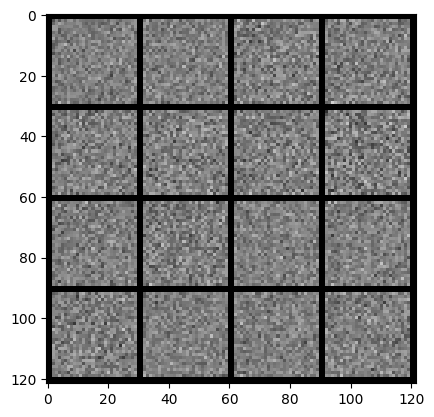

In [ ]:
x, y = next(iter(dataloader))

print(x.shape, y.shape)

print(y[:10])

noise = gen_noise(bs, z_dim)

fake = gen(noise)

show(fake)


In [ ]:
#Calculating the loss

#Generator Loss

def calc_gen_loss(loss_func, gen, disc, number, z_dim):
    noise = gen_noise(number, z_dim)
    fake = gen(noise)
    pred = disc(fake)
    targets = torch.ones_like(pred)
    gen_loss = loss_func(pred, targets)
    return gen_loss

def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
    noise = gen_noise(number, z_dim)
    fake = gen(noise)
    disc_fake = disc(fake.detach())
    disc_fake_targets = torch.zeros_like(disc_fake)
    disc_fake_loss = loss_func(disc_fake, disc_fake_targets)

    disc_real = disc(real)
    disc_real_targets = torch.ones_like(disc_real)
    disc_real_loss = loss_func(disc_real, disc_real_targets)

    disc_loss = (disc_fake_loss + disc_real_loss)/2

    return disc_loss





In [ ]:

for epoch in range(epochs):
    for real, _ in tqdm(dataloader):
        # Discriminator
        disc_opt.zero_grad()

        cur_bs = len(real) # real : 128 x 1 x 28 x 28
        real = real.view(cur_bs, -1)
        real = real.to(device)

        disc_loss = calc_disc_loss(loss_func, gen, disc, cur_bs, real, z_dim)

        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        #Generator
        gen_opt.zero_grad()
        gen_loss = calc_gen_loss(loss_func, gen, disc, cur_bs, z_dim)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()

        #Visualization & Stats
        mean_disc_loss += disc_loss.item()/ info_step
        mean_gen_loss += gen_loss.item() / info_step

        if cur_step % info_step ==0 and cur_step >0:
            fake_noise = gen_noise(cur_bs, z_dim)
            fake = gen(fake_noise)
            show(fake)
            show(real)
            print(f"{epoch}: step {cur_step} / Gen Loss: {mean_gen_loss} / Disc_loss: {mean_disc_loss}")
            mean_gen_loss, mean_disc_loss = 0,0
        cur_step += 1





In [ ]:
#Import libraries
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Advanced GAN - Wasserstein GANs


In [1]:
import torch, torchvision, os, PIL, pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def show(tensor, num=25, wandbactive=0, name=""):
    data = tensor.detach().cpu()
    grid = make_grid(data[:num], nrow=5).permute(1,2,0)

    if (wandbactive==1):
        wandb.log({name:wandb.Image(grid.numpy().clip(0,1))})


    plt.imshow(grid.clip(0,1))
    plt.show()

## hyperparams and general params
n_epohcs = 10000
batch_size = 128
lr = 1e-4
z_dim = 200
device='cpu'

cur_step = 0
critic_cycles=5
gen_losses = []
crit_losses = []
show_step = 35
save_step = 35

wandbact = 1  #Optional


In [2]:
# Optional
!pip install wandb -qqq
import wandb

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: saionthemail (saionthemail-self) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
%%capture

experiment_name = wandb.util.generate_id()

myrun = wandb.init(
    project="wgan",
    group=experiment_name,
    config = {
        "optimizer:":"sgd",
        "model":"wgan gp",
        "epoch":"1000",
        "batch_size":128
    }
)

config = wandb.config


In [5]:
print(experiment_name)

7hyg5dsj


In [6]:
#Generator Model

class Generator(nn.Module):
    def __init__(self, z_dim=64, d_dim=16):
        super(Generator, self).__init__()
        self.z_dim = z_dim

        self.gen = nn.Sequential(
            ## ConvTranspose2D: inchannels, outchannels, kernelsize, stride, padding
            ## Calculating new width and height: (n-1)*stride - 2*padding + ks
            ## n = width or height
            ## ks = kernel size
            ## we begin with 1 x 1 image with zdim number of channels (200)
            nn.ConvTranspose2d(z_dim, d_dim*32, 4, 1, 0), ## 4 x 4 (ch: 200 512)
            nn.BatchNorm2d(d_dim*32),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*32, d_dim*16, 4,2,1), ## 8x8 (ch: 512, 256)
            nn.BatchNorm2d(d_dim*16),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*16, d_dim*8, 4,2,1), ## 16 x 16 (ch: 256, 128)
            nn.BatchNorm2d(d_dim*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*8, d_dim*4, 4,2,1), ## 32 x 32 (ch: 128, 64)
            nn.BatchNorm2d(d_dim*4),
            nn.ReLU(True),


            nn.ConvTranspose2d(d_dim*4, d_dim*2, 4,2,1), ## 64 x 64 (ch: 64, 32)
            nn.BatchNorm2d(d_dim*2),
            nn.ReLU(True),


            nn.ConvTranspose2d(d_dim*2, 3, 4,2,1), ## 128 x 128 (ch: 32, 3)
            nn.Tanh()
        )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1) #128 x 200 x 1 x 1
        return self.gen(x)

def gen_noise(num, z_dim, device='cuda'):
    return torch.randn(num, z_dim, device=device) # 128 x 200



In [7]:
class Critic(nn.Module):
    def __init__(self, d_dim=16):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            # conv2d: in_channels, out_channels, kernel_size, stride, padding
            nn.Conv2d(3, d_dim, 4, 2,1),
            nn.InstanceNorm2d(d_dim),
            nn.LeakyReLU(0.2),

            nn.Conv2d(d_dim, d_dim*2, 4, 2,1),
            nn.InstanceNorm2d(d_dim*2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(d_dim*2, d_dim*4, 4, 2,1),
            nn.InstanceNorm2d(d_dim*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(d_dim*4, d_dim*8, 4, 2,1),
            nn.InstanceNorm2d(d_dim*8),
            nn.LeakyReLU(0.2),


            nn.Conv2d(d_dim*8, d_dim*16, 4, 2,1),
            nn.InstanceNorm2d(d_dim*16),
            nn.LeakyReLU(0.2),

            nn.Conv2d(d_dim*16, 1 , 4, 2,1),
            )
    def forward(self, image):
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred),-1)


In [8]:
#Optional
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight,0.0,0.02)
        torch.nn.init.constant_(m.bias,0)
    if isinstance(m,nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight,0.0,0.02)
        torch.nn.init.constant_(m.bias,0)

# gen = gen.apply(init_weights)
# crit = crit.apply(init_weights)

In [9]:
import gdown
import os

# Create directory if it doesn't exist
os.makedirs("data/celeba", exist_ok=True)

# Extract file ID from your URL
file_id = "0B7EVK8r0v71pZjFTYXZWM3FlRnM"
url = f"https://drive.google.com/uc?id={file_id}"

# Download
gdown.download(url, "data/celeba/img_align_celeba.zip", quiet=False)

FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM

but Gdown can't. Please check connections and permissions.

In [ ]:
download_path = "data/celeba/img_align_celeba.zip"
path = "data/celeba/"

In [ ]:
with zipfile.ZipFile(download_path, 'r') as ziphandler:
    ziphandler.extractall(path)

In [ ]:
### Dataset, DataLoader, Declare Gen, Critic, Test Dataset
from torch.utils.data import Dataset
class Dataset(Dataset):
    def __init__(self, path, size=128, lim=10000):
        self.sizes = [size, size]
        items, labels = [], []
        for data in os.listdir(path)[:lim]:
            item = os.path.join(path,data)
            items.append(item)
            labels.append(data)
        self.items =  items
        self.labels = labels
    def __len__(self):
        return len(self.items)
    def __getitem__(self, idx):
        data = PIL.Image.open(self.items[idx]).convert('RGB') #(178,218)
        data = np.asarray(torchvision.transforms.Resize(self.sizes)(data)) #128 x 128
        data = np.transpose(data, (2,0,1)).astype(np.float32, copy=False)
        data = torch.from_numpy(data).div(255)
        return data, self.labels[idx]

##Dataset
data_path = "./data/celeba/img_align_celeba"
ds = Dataset(data_path, size=128, lim=10000)


##DataLoader
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

## Models
gen = Generator(z_dim).to(device)
crit = Critic().to(device)

## Optimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5,0.9))
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(0.5,0.9))


##initializations
# gen = gen.apply(init_weights)
# crit = crit.apply(init_weights)


#Wandb
if (wandbact==1):
    wandb.watch(gen,log_freq=100)
    wandb.watch(crit,log_freq=100)

x,y = next(iter(dataloader))
show(x)

In [ ]:
## gradient penalty calculation
def get_gp(real, fake, crit, alpha, gamma=10):
    mix_images = real * alpha + fake * (1-alpha) #128 x 3 x 128 x 128
    mix_scores = crit(mix_images) #128 x 1

    gradient = torch.autograd.grad(
        inputs = mix_images,
        outputs = mix_scores,
        grad_outputs = torch.ones_like(mix_scores),
        retain_graph = True,
        create_graph = True,
    )[0]

    gradient = gradient.view(len(gradient),-1) #128 x 49152
    gradient_norm = gradient.norm(2,dim=1)
    gp = gamma * ((gradient_norm-1)**2).mean()

    return gp


In [ ]:
## Save and load checkpoints

root_path = "./data/"

def save_checkpoint(name):
    torch.save({
        'epoch':epoch,
        'model_state_dict': gen.state_dict(),
        'optimizer_state_dict':gen_opt.state_dict()
    }, f"{root_path}G-{name}.pkl")

    torch.save({
        'epoch':epoch,
        'model_state_dict':crit.state_dict(),
        'optimizer_state_dict':crit_opt.state_dict()
    }, f"{root_path}C-{name}.pkl")

    print("Saved Checkpoint")

def load_checkpoint(name):
    checkpoint = torch.load(f"{root_path}G-{name}.pkl")
    gen.load_state_dict(checkpoint['model_state_dict'])
    gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

    checkpoint = torch.load(f"{root_path}G-{name}.pkl")
    crit.load_state_dict(checkpoint['model_state_dict'])
    crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

    print("Loaded checkpoint")

In [ ]:
# Training Loop

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_bs = len(real) #128
        real = real.to(device)

        ## Critic
        mean_crit_loss = 0
        for _ in range(crit_cycles):
            crit_opt.zero_grad()
            noise = gen(noise)
            fake = gen(noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            alpha = torch.rand(len(real),1,1,1,device=device, requires_grad=True)
            gp = get_gp(real, fake.detach(), crit, alpha)
            crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp

            mean_crit_loss += crit_loss.item() / crit_cycles

            crit_loss.backward(retain_graph=True)
            crit_opt.step()
        crit_losses += [mean_crit_loss]

        ## Generator
        gen_opt.zero_grad()
        noise = gen_noise(cur_bs, z_dim)
        fake = gen(noise)
        crit_fake_pred = crit(fake)


        gen_loss = -crit_fake_pred.mean()
        gen_loss.backward()
        gen_opt.step()


        gen_losses += [gen_loss.item()]

        ##stats

        if (wandbact == 1):
            wandb.log({'Epoch':epoch, 'Step': cur_step, 'Critic Loss': mean_crit_loss, 'Gen loss': gen_loss})

        if cur_step % save_step == 0 and cur_step >0:
            print("Saving Checkpoint: ", cur_step, save_step)
            save_checkpoint("latest")


        if (cur_step % show_step == 0 and cur_step >0):
            show(fake, wandbactive=1, name='fake')
            show(real, wandbactive=1, name='real')

            gen_mean = sum(gen_loss[-show_step:]) / show_step
            crit_mean = sum(crit_losses[-show_step:])/show_step
            print(f"Epoch: {epoch}: Step {cur_step}: Generator Loss: {gen_mean}, critic loss: {crit_mean}")
            plt.plot(
                range(len(gen_losses)),
                torch.Tensor(gen_losses),
                label= "Generator Loss"
            )

            plt.plot(
                range(len(gen_losses)),
                torch.Tensor(gen_losses),
                label= "Critic Loss"
            )

            plt.ylim(-1000,1000)
            plt.legend()
            plt.show()
        cur_step += 1


In [ ]:
 #Morphing, Interpolation between points in latent space
from mpl_toolkits.axes.grid1 import ImageGrid
gen_set = []
z_shape = [1,200,1,1]
rows = 4
steps = 17

for i in range(rows):
z1, z2 = torch.randn(z_shape), torch.randn(z_shape)
for alpha in np.linspace(0,1,steps):
    z = alpha * z1 + (1-alpha)*z2
    res = gen(z.cuda())[0]
    gen_set.append(res)

fig = plt.figure(figsize=(25,11))
grid = ImageGrid(fig, 111, nrows_ncols=(rows, steps), axes_pad=0.1)

for ax, img in zip(grid, gen_set):
    ax.axis('off')
    res=img.cpu().detach().permute(1,2,0)
    res = res - res.min()
    res = res / (res.max() - res.min())
    ax.imshow(res)
plt.show()